# AAI-511 Final Project

Paul Parks

## Libraries

pretty-midi is used for midi calculations (key, tempo, etc):
https://github.com/craffel/pretty-midi

keras-tuner is used for hyperparameter tuning

In [1]:
# %pip install pretty_midi 
# %pip install keras-tuner


In [2]:
import os
import pretty_midi
import numpy as np
import mido
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, Bidirectional, Attention
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from kerastuner.tuners import RandomSearch
from sklearn.utils.class_weight import compute_class_weight

C:\Users\paula\AppData\Local\Temp\ipykernel_27652\1196650512.py:15: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## Data Collection
Data is collected and provided to you.

**Dataset**

The project will use a dataset consisting of musical scores from various composers. Download the dataset from Kaggle websiteLinks to an external site..

https://www.kaggle.com/datasets/blanderbuss/midi-classic-music/data

The dataset contains the midi files of compositions from well-known classical composers like Bach, Beethoven, Chopin, and Mozart. The dataset should be labeled with the name of the composer for each score. Please only do your prediction only for below composers, therefore you need to select the required composers from the given dataset above.

1. Bach
1. Beethoven
1. Chopin
1. Mozart

## Data Pre-processing
Convert the musical scores into a format suitable for deep learning models. This involves converting the musical scores into MIDI files and applying data augmentation techniques.

In [3]:
def load_midi_files(base_dir, composers):
    midi_files = []
    labels = []

    for composer in composers:
        composer_dir = os.path.join(base_dir, composer)
        for root, _, files in os.walk(composer_dir):
            for file in files:
                if file.endswith('.mid') or file.endswith('.midi'):
                    midi_files.append(os.path.join(root, file))
                    labels.append(composer)
    return midi_files, labels

base_dir = './Dataset/midiclassics/'
composers = ['Bach', 'Beethoven', 'Chopin', 'Mozart']

midi_files, labels = load_midi_files(base_dir, composers)

print('Number of MIDI files:', len(midi_files))
print('Number of labels:', len(labels))

# print files per composer
for composer in composers:
    print(f'{composer}: {labels.count(composer)}')

Number of MIDI files: 1530
Number of labels: 1530
Bach: 925
Beethoven: 212
Chopin: 136
Mozart: 257


## Feature Extraction
Extract features from the MIDI files, such as notes, chords, and tempo, using music analysis tools.


### Make all midi the same key

My first idea was to make all of the music in the same key so our model could easily identify the notes and chords for classification

In [4]:
def extract_key_signature(midi_data):
    key_signatures = midi_data.key_signature_changes
    if key_signatures:
        key_signature = key_signatures[0].key_number
    else:
        key_signature = 0  # C major or A minor
    return key_signature

def transpose_to_c_major(midi_data):
    key_signature_changes = midi_data.key_signature_changes
    if key_signature_changes:
        original_key = key_signature_changes[0].key_number
        semitones_to_c_major = -original_key
        for instrument in midi_data.instruments:
            for note in instrument.notes:
                note.pitch += semitones_to_c_major
    return midi_data

### Notes and chords

I also tried to calculate different chords used in each piece of music. I created a note histogram for all 12 notes instead of trying to look at all of the different octaves used in each piece.

In [5]:
def extract_chords(midi_data, time_window=0.05):
    chords = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            notes = sorted(instrument.notes, key=lambda note: note.start)
            current_chord = []
            current_start_time = notes[0].start if notes else None
            
            for note in notes:
                if current_start_time is not None and note.start - current_start_time > time_window:
                    if len(current_chord) > 1:
                        chords.append(current_chord)
                    current_chord = []
                    current_start_time = note.start
                
                current_chord.append(note)
            
            if len(current_chord) > 1:
                chords.append(current_chord)
    
    return chords

COMMON_CHORDS = {
    'major': (0, 4, 7),
    'minor': (0, 3, 7),
    'diminished': (0, 3, 6),
    'augmented': (0, 4, 8),
    'dominant_seventh': (0, 4, 7, 10),
    'major_seventh': (0, 4, 7, 11),
    'minor_seventh': (0, 3, 7, 10),
    'suspended_fourth': (0, 5, 7),
    'suspended_second': (0, 2, 7),
    'perfect_fourth': (0, 5, 9),
    'sixth_chord': (0, 4, 9),
    'unknown_1': (0, 4, 5, 9),
    'unknown_2': (0, 6, 9),
    'unknown_3': (0, 2, 6, 9),
    'unknown_4': (2, 5, 11),
    'unknown_5': (3, 6, 11),
    'unknown_6': (1, 6, 11),
    'other': (),
}

def extract_chord_histogram(midi_data, common_chords=COMMON_CHORDS, time_window=0.05):
    histogram = {chord: 0 for chord in common_chords}
    unknown_chords = set()
    chords = extract_chords(midi_data, time_window)
    
    for chord in chords:
        pitches = sorted(set(note.pitch % 12 for note in chord))
        if len(pitches) >= 3:
            recognized = False
            for chord_name, intervals in common_chords.items():
                if len(pitches) == len(intervals):
                    if all((pitches[i+1] - pitches[i]) % 12 == intervals[i+1] - intervals[i] for i in range(len(intervals) - 1)):
                        histogram[chord_name] += 1
                        recognized = True
                        break
            if not recognized:
                histogram['other'] += 1
                unknown_chords.add(tuple(pitches))
    
    return np.array(list(histogram.values())), unknown_chords

def extract_note_histogram(midi_data):
    histogram = np.zeros(12)
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                histogram[note.pitch % 12] += 1
    return histogram


### Notes in order

I tried to use the actually music in the prediction but was unsuccessful in having good metrics from this approach. I left some of the code here to see the approach that was taken

In [6]:
def extract_pitch_classes_and_durations(midi_data):
    pitch_classes = []
    durations = []
    for instrument in midi_data.instruments:
        if not instrument.is_drum:
            for note in instrument.notes:
                pitch_classes.append(note.pitch % 12)  # Convert to pitch class
                durations.append(note.end - note.start)
    return pitch_classes, durations

## Features

Use the helper functions to create all of the features for our prediction

In [7]:
def pad_or_truncate(array, max_length):
    array = np.array(array)
    array = array[array > 0]
    if len(array) > max_length:
        return array[:max_length]
    else:
        return np.pad(array, (0, max_length - len(array)), 'constant')

def extract_tempo(midi_data):
    tempos = midi_data.get_tempo_changes()
    return tempos

def extract_features(midi_file):
    try:
        midi_data = pretty_midi.PrettyMIDI(midi_file)
        key_signature = extract_key_signature(midi_data)
        midi_data = transpose_to_c_major(midi_data)
        note_histogram = extract_note_histogram(midi_data)
        tempos = extract_tempo(midi_data)
        chord_histogram, unknown_chords = extract_chord_histogram(midi_data)
        pitch_classes, durations = extract_pitch_classes_and_durations(midi_data)

        return note_histogram, chord_histogram, tempos, key_signature, pitch_classes
    except (mido.KeySignatureError, KeyError) as e:
        print(f"Error processing {midi_file}: {e}")
        return None, None, None, None, None

def prepare_feature_data(composers):
    MAX_TEMPOS = 5

    rows = [] 
    X = []
    y = []

    for i, file in enumerate(midi_files):
        composer = labels[i]
        note_histogram, chord_histogram, tempos, key_signature, pitch_classes = extract_features(file)
        if note_histogram is not None:
            tempos = pad_or_truncate(tempos[1], MAX_TEMPOS) if len(tempos) > 1 else np.zeros(MAX_TEMPOS)

            rows.append({
                'composer': composer,
                'note_histogram': note_histogram,
                'chord_histogram': chord_histogram,
                'tempos': tempos,
                'key_signature': key_signature
            })

            
            sequence_length = 100
            # trim or pad the pitch classes to the sequence length
            pitch_classes = pad_or_truncate(pitch_classes, sequence_length)
            

            features = np.concatenate([
                note_histogram.flatten(),
                chord_histogram.flatten(),
                tempos.flatten(),
                np.array([key_signature]),
            ])
            X.append(features)

            y.append(composers.index(composer))
        else:
            print(f"Skipping {file}")

    df = pd.DataFrame(rows)

    X = pad_sequences(X, maxlen=sequence_length, padding='post')

    X_arr = np.array(X)
    y_arr = np.array(y)

    scaler = StandardScaler()
    X_arr = scaler.fit_transform(X_arr)

    X_train, X_val, y_train, y_val = train_test_split(X_arr, y_arr, test_size=0.2, random_state=42)
    return df, X, y, X_train, X_val, y_train, y_val

# Usage
df, X, y, X_train, X_val, y_train, y_val = prepare_feature_data(composers)


C:\Users\paula\AppData\Roaming\Python\Python39\site-packages\pretty_midi\pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Error processing ./Dataset/midiclassics/Beethoven\Anhang 14-3.mid: Could not decode key with 3 flats and mode 255
Skipping ./Dataset/midiclassics/Beethoven\Anhang 14-3.mid
Error processing ./Dataset/midiclassics/Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid: Could not decode key with 2 flats and mode 2
Skipping ./Dataset/midiclassics/Mozart\Piano Sonatas\Nueva carpeta\K281 Piano Sonata n03 3mov.mid


### Feature visibility

The Dataframe is create for EDA and visibility

In [8]:
df.head()

,composer,note_histogram,chord_histogram,tempos,key_signature
0,Bach,"[136.0, 5.0, 72.0, 12.0, 65.0, 181.0, 4.0, 112...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[120.0, 0.0, 0.0, 0.0, 0.0]",0
1,Bach,"[759.0, 195.0, 583.0, 863.0, 132.0, 806.0, 74....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[75.0, 70.00007000007, 65.000065000065, 50.0, ...",0
2,Bach,"[868.0, 82.0, 646.0, 648.0, 122.0, 691.0, 85.0...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[80.0, 78.00007800007802, 75.0, 70.00023333411...",0
3,Bach,"[624.0, 214.0, 860.0, 145.0, 710.0, 711.0, 147...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[60.0, 50.0, 30.0, 60.0, 55.000004583333705]",0
4,Bach,"[295.0, 243.0, 446.0, 139.0, 671.0, 70.0, 554....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[40.0, 75.0, 70.00007000007, 65.000065000065, ...",0


In [9]:
print('Number of samples:', len(X))
print('Number of labels:', len(y))
print('Feature vector length:', len(X[0]))

# count unique labels
unique_labels = set(y)
print('Unique labels:', unique_labels)

# Count samples per label
for label in unique_labels:
    print(f'{composers[label]}: {y.count(label)}')

Number of samples: 1528
Number of labels: 1528
Feature vector length: 100
Unique labels: {0, 1, 2, 3}
Bach: 925
Beethoven: 211
Chopin: 136
Mozart: 256


## Model Building
Develop a deep learning model using LSTM and CNN architectures to classify the musical scores according to the composer.


### LSTM

In [10]:
def create_lstm(input_shape, num_classes):
    model = Sequential()
    model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=False)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### CNN

In [11]:
def create_cnn(input_shape, num_classes):
    model = Sequential()
    model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(2))
    model.add(Conv1D(128, 3, activation='relu'))
    model.add(MaxPooling1D(2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

## Model Training
Train the deep learning model using the pre-processed and feature-extracted data.


In [12]:
input_shape = (X_train.shape[1], 1)
num_classes = len(composers)

In [13]:
lstm_model = create_lstm(input_shape, num_classes)
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 100, 256)         133120    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 batch_normalization (BatchN  (None, 64)               2

In [14]:
cnn_model = create_cnn(input_shape, num_classes)
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 98, 64)            256       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 49, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 47, 128)           24704     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 23, 128)          0         
 1D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2944)              0         
                                                                 
 dense_2 (Dense)             (None, 128)              

In [15]:
# train and fit 
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [16]:
lstm_history = lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
39/39 [==============================] - 4s 35ms/step - loss: 1.2452 - accuracy: 0.5777 - val_loss: 1.2016 - val_accuracy: 0.6307
Epoch 2/50
39/39 [==============================] - 1s 20ms/step - loss: 1.0710 - accuracy: 0.6203 - val_loss: 1.1065 - val_accuracy: 0.6078
Epoch 3/50
39/39 [==============================] - 1s 20ms/step - loss: 0.9758 - accuracy: 0.6489 - val_loss: 1.0276 - val_accuracy: 0.5850
Epoch 4/50
39/39 [==============================] - 1s 20ms/step - loss: 0.9893 - accuracy: 0.6408 - val_loss: 1.0168 - val_accuracy: 0.5882
Epoch 5/50
39/39 [==============================] - 1s 20ms/step - loss: 0.9211 - accuracy: 0.6637 - val_loss: 0.9875 - val_accuracy: 0.5882
Epoch 6/50
39/39 [==============================] - 1s 20ms/step - loss: 0.8874 - accuracy: 0.6506 - val_loss: 0.9704 - val_accuracy: 0.5850
Epoch 7/50
39/39 [==============================] - 1s 20ms/step - loss: 0.8979 - accuracy: 0.6465 - val_loss: 0.9474 - val_accuracy: 0.5850
Epoch 8/50
39

In [17]:
cnn_history = cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopping])

Epoch 1/50
39/39 [==============================] - 1s 5ms/step - loss: 0.9627 - accuracy: 0.6260 - val_loss: 0.8557 - val_accuracy: 0.6634
Epoch 2/50
39/39 [==============================] - 0s 3ms/step - loss: 0.8181 - accuracy: 0.6817 - val_loss: 0.8437 - val_accuracy: 0.6797
Epoch 3/50
39/39 [==============================] - 0s 3ms/step - loss: 0.7629 - accuracy: 0.6980 - val_loss: 0.8050 - val_accuracy: 0.6732
Epoch 4/50
39/39 [==============================] - 0s 3ms/step - loss: 0.7141 - accuracy: 0.7201 - val_loss: 0.7767 - val_accuracy: 0.7092
Epoch 5/50
39/39 [==============================] - 0s 3ms/step - loss: 0.6891 - accuracy: 0.7300 - val_loss: 0.8009 - val_accuracy: 0.6765
Epoch 6/50
39/39 [==============================] - 0s 3ms/step - loss: 0.6596 - accuracy: 0.7455 - val_loss: 0.7446 - val_accuracy: 0.7059
Epoch 7/50
39/39 [==============================] - 0s 3ms/step - loss: 0.6510 - accuracy: 0.7561 - val_loss: 0.7147 - val_accuracy: 0.7059
Epoch 8/50
39/39 [==

## Model Evaluation
Evaluate the performance of the deep learning model using accuracy, precision, and recall metrics.


In [18]:
def plot_history(history, title):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

def evaluate_model(model, X, y, history, name):
    loss, accuracy = model.evaluate(X, y)
    print(f'{name} Accuracy: {accuracy:.2f}')

    plot_history(history, name)

    predictions = model.predict(X_val)
    predictions = np.argmax(predictions, axis=1)

    print('{name} Classification Report')
    print(classification_report(y_val, predictions))

### LSTM Evaluation

10/10 [==============================] - 0s 13ms/step - loss: 0.8636 - accuracy: 0.6373
LSTM Accuracy: 0.64


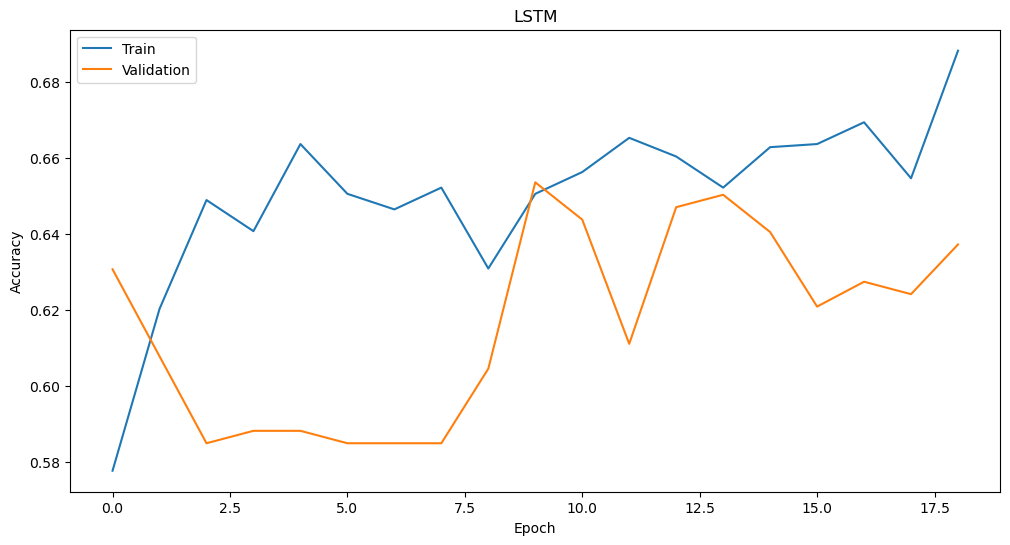

10/10 [==============================] - 1s 14ms/step
{name} Classification Report
              precision    recall  f1-score   support

           0       0.70      0.93      0.80       175
           1       0.65      0.19      0.30        57
           2       0.41      0.43      0.42        28
           3       0.35      0.20      0.25        46

    accuracy                           0.64       306
   macro avg       0.53      0.44      0.44       306
weighted avg       0.61      0.64      0.59       306



In [19]:
evaluate_model(lstm_model, X_val, y_val, lstm_history, 'LSTM')

10/10 [==============================] - 0s 2ms/step - loss: 0.6268 - accuracy: 0.7614
CNN Accuracy: 0.76


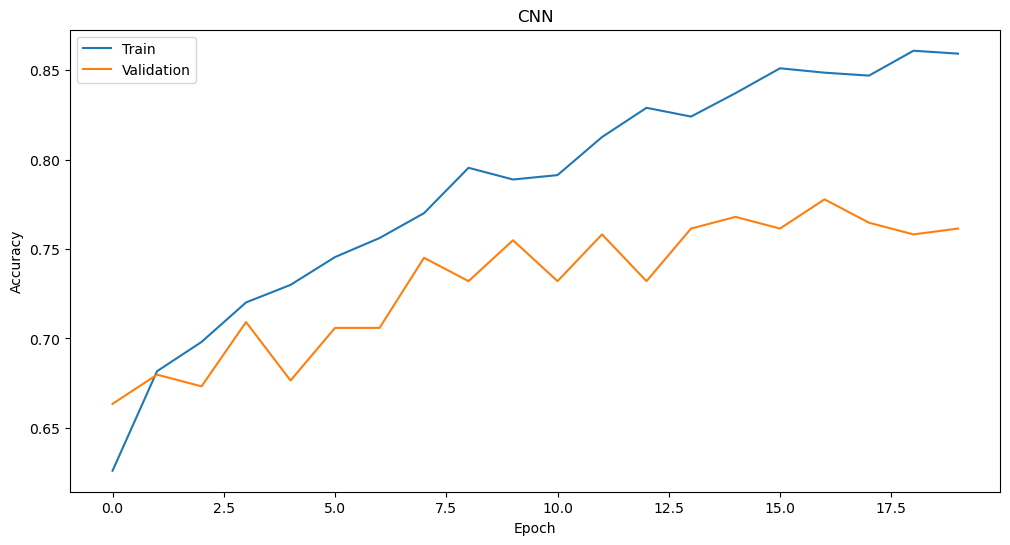

10/10 [==============================] - 0s 1ms/step
{name} Classification Report
              precision    recall  f1-score   support

           0       0.81      0.97      0.88       175
           1       0.70      0.49      0.58        57
           2       0.65      0.61      0.63        28
           3       0.59      0.41      0.49        46

    accuracy                           0.76       306
   macro avg       0.69      0.62      0.64       306
weighted avg       0.74      0.76      0.74       306



In [20]:
evaluate_model(cnn_model, X_val, y_val, cnn_history, 'CNN')

## Model Optimization
Optimize the deep learning model by fine-tuning hyperparameters.


In [21]:
# class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
# class_weights_dict = dict(enumerate(class_weights))
# print('Class weights:', class_weights_dict)

### LSTM

In [22]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_lstm_model.h5', monitor='val_loss', save_best_only=True)

def build_model(hp):
    model = Sequential()
    model.add(Bidirectional(LSTM(hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=True), input_shape=input_shape))
    model.add(Bidirectional(LSTM(hp.Int('units', min_value=32, max_value=256, step=32), return_sequences=False)))
    model.add(Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(BatchNormalization())
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model, objective='val_accuracy', max_trials=10, executions_per_trial=2, directory='tuner_lstm', project_name='composer_classification_lstm')

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
lstm_tuned = tuner.hypermodel.build(best_hps)
history = lstm_tuned.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr, checkpoint])


Trial 10 Complete [00h 01m 29s]
val_accuracy: 0.6568627655506134

Best val_accuracy So Far: 0.7026143968105316
Total elapsed time: 00h 09m 28s
Epoch 1/100
39/39 [==============================] - 4s 44ms/step - loss: 1.1020 - accuracy: 0.6113 - val_loss: 1.0782 - val_accuracy: 0.6046 - lr: 0.0025
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 0.9304 - accuracy: 0.6604 - val_loss: 1.0530 - val_accuracy: 0.5719 - lr: 0.0025
Epoch 3/100
39/39 [==============================] - 1s 18ms/step - loss: 0.8616 - accuracy: 0.6612 - val_loss: 1.0501 - val_accuracy: 0.5719 - lr: 0.0025
Epoch 4/100
39/39 [==============================] - 1s 18ms/step - loss: 0.9029 - accuracy: 0.6530 - val_loss: 0.9959 - val_accuracy: 0.5719 - lr: 0.0025
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 0.8548 - accuracy: 0.6579 - val_loss: 0.9684 - val_accuracy: 0.5719 - lr: 0.0025
Epoch 6/100
39/39 [==============================] - 1s 19ms/step - loss: 0.8429 -

10/10 [==============================] - 0s 8ms/step - loss: 0.8183 - accuracy: 0.6569
Tuned LSTM Accuracy: 0.66


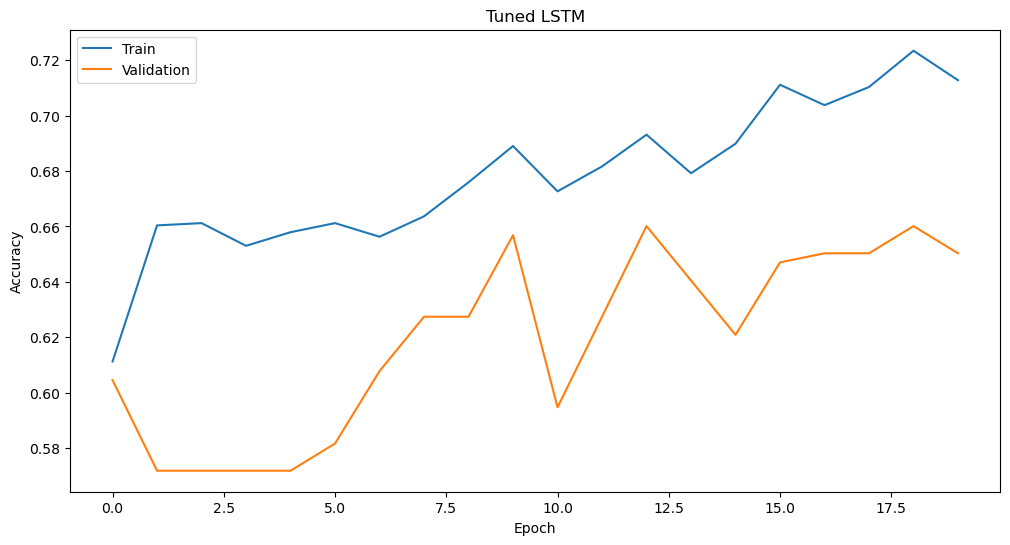

10/10 [==============================] - 1s 7ms/step
{name} Classification Report
              precision    recall  f1-score   support

           0       0.71      0.94      0.81       175
           1       0.55      0.21      0.30        57
           2       0.52      0.46      0.49        28
           3       0.41      0.24      0.30        46

    accuracy                           0.66       306
   macro avg       0.55      0.46      0.48       306
weighted avg       0.62      0.66      0.61       306



In [23]:
lstm_tuned.load_weights('best_lstm_model.h5')

evaluate_model(lstm_tuned, X_val, y_val, history, 'Tuned LSTM')

### CNN

In [24]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint = ModelCheckpoint('best_cnn_model.h5', monitor='val_loss', save_best_only=True)

def build_model(hp):
    model = Sequential()
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=256, step=32), kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=hp.Int('filters_2', min_value=32, max_value=256, step=32), kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='tuner_cnn',
    project_name='composer_classification_cnn'
)

tuner.search(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it
cnn_tuned = tuner.hypermodel.build(best_hps)
history = cnn_tuned.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr, checkpoint])


Trial 10 Complete [00h 00m 10s]
val_accuracy: 0.7647058665752411

Best val_accuracy So Far: 0.7957516312599182
Total elapsed time: 00h 01m 53s
Epoch 1/100
39/39 [==============================] - 0s 5ms/step - loss: 0.8796 - accuracy: 0.6391 - val_loss: 0.8259 - val_accuracy: 0.6797 - lr: 0.0023
Epoch 2/100
39/39 [==============================] - 0s 4ms/step - loss: 0.7433 - accuracy: 0.7062 - val_loss: 0.8014 - val_accuracy: 0.6732 - lr: 0.0023
Epoch 3/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6794 - accuracy: 0.7218 - val_loss: 0.7508 - val_accuracy: 0.7124 - lr: 0.0023
Epoch 4/100
39/39 [==============================] - 0s 4ms/step - loss: 0.6594 - accuracy: 0.7406 - val_loss: 0.7637 - val_accuracy: 0.6895 - lr: 0.0023
Epoch 5/100
39/39 [==============================] - 0s 4ms/step - loss: 0.5989 - accuracy: 0.7496 - val_loss: 0.7793 - val_accuracy: 0.7059 - lr: 0.0023
Epoch 6/100
39/39 [==============================] - 0s 4ms/step - loss: 0.5524 - accur

10/10 [==============================] - 0s 2ms/step - loss: 0.6391 - accuracy: 0.7484
Tuned CNN Accuracy: 0.75


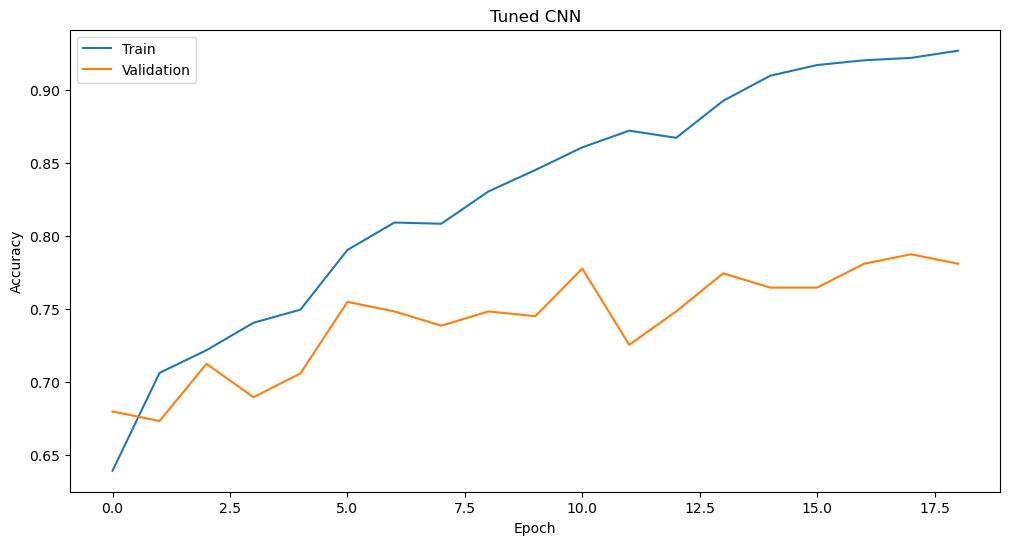

10/10 [==============================] - 0s 1ms/step
{name} Classification Report
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       175
           1       0.82      0.40      0.54        57
           2       0.54      0.75      0.63        28
           3       0.46      0.59      0.51        46

    accuracy                           0.75       306
   macro avg       0.67      0.66      0.64       306
weighted avg       0.77      0.75      0.74       306



In [25]:
cnn_tuned.load_weights('best_cnn_model.h5')

evaluate_model(cnn_tuned, X_val, y_val, history, 'Tuned CNN')